![NVIDIA](images/nvidia.png)

# Agents

In this notebook we introduce agents which can reason about tool use and integrate the actual invocation of tools into LLM responses.

---

## Objectives

By the time you complete this notebook you will:

- Understand the role of agents in the context of LLM tool use.
- Create and utilize a simple agent capable of folding tool use results into LLM responses.
- Integrate agents you create into LCEL chains.

---

## Imports

In [1]:
import requests

from langchain_nvidia_ai_endpoints import ChatNVIDIA

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate

from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display

---

## Create a Model Instance

In [2]:
base_url = 'http://llama:8000/v1'
model = 'meta/llama-3.1-8b-instruct'
llm = ChatNVIDIA(base_url=base_url, model=model, temperature=0)

---

## Agents

In the previous notebook we learned how to create tools, use LLMs to indicate when and how to invoke tools, and then, engineered a naive system of actually invoking tools when the LLM indicated we should.

The naive approach we took lacked some very key features, perhaps the most important that we were unable to provide the LLM with the actual result of invoking its tool so that it could use the tool's result to inform its response to the user. To address this issue, and to facilitate many much more powerful capabilities, we tend to create **agents**.

The [LangChain docs](https://python.langchain.com/v0.2/docs/concepts/#agents) have an excellent description of agents:
> By themselves, language models can't take actions - they just output text. A big use case for LangChain is creating agents. Agents are systems that use an LLM as a reasoning engine to determine which actions to take and what the inputs to those actions should be. The results of those actions can then be fed back into the agent and it determines whether more actions are needed, or whether it is okay to finish.

While the topic of agents is really big, and is deserving of its own deep study, we want to give some coverage to agents in this workshop, and are happy to give you a chance to use them, at least in a simple fashion.

---

## A Tool for an Agent

It should come as no surprise that before we can think about creating agents, we need to create tools that an agent might decide to use. We'll re-create here our simple multiplication tool.

In [3]:
class Multiply(BaseModel):
    """Use when needed to get the product of multiplying two integers together."""
    a: int = Field(..., description="First integer to multiply.")
    b: int = Field(..., description="Second integer to multiply.")

In [4]:
@tool(args_schema=Multiply)
def multiply(a: int, b: int) -> int:
    return a * b 

Here we do a quick sanity check to make sure the multiply tool behaves as expected.

In [5]:
multiply.invoke({'a': 12, 'b': 10})

120

And we create a `tools` list containing our `multiply` tool for use later in the notebook.

In [6]:
tools = [multiply] 

---

## Creating a Simple Agent with LangGraph

To create an agent capable of utilizing tools when appropriate, and integrating the result of a tool call into its response, we will use [LangGraph](https://langchain-ai.github.io/langgraph/).

LangGraph is a spinoff open-source project from the folks who created LangChain. At a high level, LangGraph promotes the easy creation of graph-based workflows. Graphs are a collection of nodes, each responsible for doing some sort of computational work, and edges, which map between nodes and define when and how nodes will be invoked to perform work.

We are going to limit our work with LangGraph here to using a simple, yet powerful, prebuilt agent that ships with LangGraph, but if you find yourself wanting to learn more about agent creation, we highly recommend taking the time to learn more about [LangGraph](https://langchain-ai.github.io/langgraph/).

---

## Creating a Simple Agent with LangGraph

As we mentioned above, agent creation is a large topic worthy of its own coverage. However, LangGraph ships with some pre-built graphs that are very easy to use, and we are going to leverage one of them in this workshop, namely, a **ReAct** agent graph.

**ReAct** stands for "Reason and Act" ([link to paper](https://arxiv.org/abs/2210.03629)). For this workshop we can think about the ReAct paradigm as a way of instructing an LLM to reason about whether or not it should use an external tool, or tools, and then when appropriate, utilize these tools before generating a final response.

With LangGraph, to create a ReAct agent, we can simply import the `create_react_agent` function, and pass it an LLM instance (created above), and a list of tools (also created above) that the agent should have access to.

In [7]:
from langgraph.prebuilt import create_react_agent

In [8]:
agent = create_react_agent(llm, tools=tools)

We can use some helper methods on the agent to get a visual of how the agent graph is constructed.

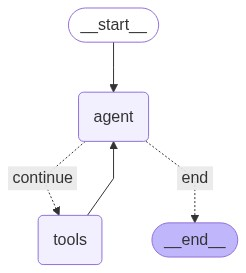

In [9]:
display(Image(agent.get_graph().draw_mermaid_png()))

As mentioned above, the graph consists of nodes, capable of performing work, and edges which describe how data ought to be passed between nodes in order to accomplish work.

In the above image we can see that at the start of the graph, incoming data will be routed to `agent` which in our case is our LLM instance which under the hood, by LangGraph, has been prompted to reason about whether or not to utilize any tools we provided to the agent. Depending on whether or not the LLM believes a tool should be utilized, the agent will either continue on to the `tools` node, where an appropriate tool will be invoked, then returning its return value back to the agent. Or, either if no tool needs calling, or all necessary tools have already been called, the agent node will send a final response to the end of the graph, where it can be viewed by the end user.

---

## Invoking the Agent

LangGraph graphs are stateful, meaning, every graph has some state defined (usually a dict) that different parts of the graph can read from and write to.

In the case of the pre-built `create_react_agent` graph we are using here, the graph's state has already been defined for us as a dict with a single `messages` key which itself contains a list of messages.

What this means for us presently is that when we use the `agent` graph, we need to add our human message prompt to its state, namely, the `messages` property of a dict, and, that any other activity (such as AI messages) in the graph will also be added to this same `messages` property.

Just like LangChain chains, our LangGraph agent has `invoke`, `batch` and `stream` methods on it. To begin, let's use the `invoke` method on the graph using a simple prompt, and one where we would not expect the agent to believe it requires the use of the `multiply` tool we have provided.

The return value of invoking the graph will be the state of the agent graph after it completes, which we'll store in a variable for further exploration below.

In [10]:
agent_state = agent.invoke({"messages": ["Give a short summary of directed cyclical graphs in the context of computer science."]})

`agent_state` will be the current state of the graph, and looking at it here we see that it is a dict with a `messages` key comprised of all the messages sent to and generated by the graph. In our case we have the `HumanMessage` that we sent into the graph, as well as the `AIMessage` response from the LLM.

In [11]:
print(agent_state)

{'messages': [HumanMessage(content='Give a short summary of directed cyclical graphs in the context of computer science.', id='b457669d-a2d0-47f5-bc49-42366dfe5368'), AIMessage(content='Directed cyclical graphs are a type of graph in computer science where edges have direction and there is at least one path that starts and ends at the same vertex, forming a cycle. This means that it is possible to traverse the graph in a loop, visiting the same vertex multiple times. Directed cyclical graphs are commonly used to model real-world systems where there are relationships between objects that have direction, such as social networks, traffic flow, or computer networks. They are also used in algorithms for tasks such as topological sorting, finding strongly connected components, and finding the shortest path in a graph.', response_metadata={'role': 'assistant', 'content': 'Directed cyclical graphs are a type of graph in computer science where edges have direction and there is at least one path

As a convenience, LangGraph messages have a `pretty_print` method. Let's loop over the messages and use this helper method to get a clearer read out.

In [12]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

Give a short summary of directed cyclical graphs in the context of computer science.
================================== Ai Message ==================================

Directed cyclical graphs are a type of graph in computer science where edges have direction and there is at least one path that starts and ends at the same vertex, forming a cycle. This means that it is possible to traverse the graph in a loop, visiting the same vertex multiple times. Directed cyclical graphs are commonly used to model real-world systems where there are relationships between objects that have direction, such as social networks, traffic flow, or computer networks. They are also used in algorithms for tasks such as topological sorting, finding strongly connected components, and finding the shortest path in a graph.


Here we see more plainly the human message we passed into the agent graph, and the AI message response it generated.

---

## Invoking the Agent to Use a Tool

Next let's invoke our agent graph, but this time with a prompt where we would expect the agent to use the `multiply` tool we have provided it.

In [13]:
agent_state = agent.invoke({"messages": ["What is 19944 times 2342?"]})

Let's again loop over the messages in the returned state, using the `pretty_print` helper for a clean view of all the messages.

In [14]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 19944 times 2342?
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-88b84eeddf5742df80cf07b9bdcfec9b)
 Call ID: chatcmpl-tool-88b84eeddf5742df80cf07b9bdcfec9b
  Args:
    a: 19944
    b: 2342
================================= Tool Message =================================
Name: multiply

46708848
================================== Ai Message ==================================

The product of 19944 and 2342 is 46708848.


Here we see our initial human message, but now, as we might expect from what we learned in the previous notebook, rather than the AI message returning a response, it instead indicates the need for a tool call. After the AI message we see a new kind of message, a tool message, which is a message from the tool (in this case `multiply`) along with the value it returned after being invoked. Finally, we have another AI message which generates a response to the initial human message, using the result of the tool call in its response.

Thus we observe how agents truly unlock the capabilities of tool creation. The agent is itself able to reason about when a tool ought to be used, is able to actually call the tool, and then is able to construct a meaningful response back to the user using the value of the resulting tool call.

Let's try one more prompt, but this time using a prompt that ought to require that the `multiply` tool be used more than once.

In [15]:
agent_state = agent.invoke({"messages": ["What is 19944 times 2342? Also, what is 9877 time 22875?"]})

Let's again loop over the messages to see what occured within the agent graph.

In [16]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 19944 times 2342? Also, what is 9877 time 22875?
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-9cb3d150c777404084059ec7a933d15b)
 Call ID: chatcmpl-tool-9cb3d150c777404084059ec7a933d15b
  Args:
    a: 19944
    b: 2342
================================= Tool Message =================================
Name: multiply

46708848
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-a8da10f4f0bf43699ab7f3fbb6625031)
 Call ID: chatcmpl-tool-a8da10f4f0bf43699ab7f3fbb6625031
  Args:
    a: 9877
    b: 22875
================================= Tool Message =================================
Name: multiply

225936375
================================== Ai Message ==================================

The product of 19944 and 2342 is 46,708,848. The product of 9877 and 22875 is 22

Given the prompt which asked about 2 different multiplication problems, the agent was successfully able to make 2 separate tool calls and only after making them both, synthesize the results of both tool calls into its final response.

---

## Inadvertent Tool Use

As an experiment, let's send another message into our agent where we would not expect the agent to use the `multiply` tool we have provided it.

In [17]:
agent_state = agent.invoke({"messages": ["In what year was NVIDIA founded?"]}) # The actual answer is 1993

In [18]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

In what year was NVIDIA founded?
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-d98421469534477fa1b103f74f9cc6f7)
 Call ID: chatcmpl-tool-d98421469534477fa1b103f74f9cc6f7
  Args:
    a: 1958
    b: 1
================================= Tool Message =================================
Name: multiply

1958
================================== Ai Message ==================================

NVIDIA was founded in 1958.


Unfortunately, the agent thought that it ought to use the `multiply` tool to answer this question. It's not entirely clear why, but it seems like a reasonable hypothesis that because the answer to the question was an integer, the agent thought it ought to use the tool.

Even worse, the LLM hallucinated two integer values to pass into the `multiply` tool, neither of which were the actual integer value of the year when NVIDIA was founded (which is 1993), and then used the result of this mistaken multiplication in its response.

---

## Prompt Engineer Better Tool Use

At this point in the workshop we already know the importance of specific prompting. So let's try to be more specific in our prompt in order to get the LLM agent to behave as we would like.

If we wanted we could try being more specific about when the agent ought to be using its tools by writing a longer more specific prompt, but since we are trying to impact the overarching behavior of the model, it might make more sense for us to try including a system message.

Let's try the following which is quite explicit about the behavior we would like, and utilizes zero-shot COT prompting (in the form of "Think hard about...").

In [19]:
system_message = """\
You are a helpful assistant capable of tool calling when helpful, necessary, and appropriate.

Think hard about whether or not you need to call a tool, \
based on your tools' descriptions and use them, but only when appropriate!

Whether or not you need to call a tool, address the user's query in a helpful informative way.
"""

In the case of the pre-built agent we are using, we can add a system message when instantiating it using the `state_modifier` named argument. Here's the docstring for `create_react_agent`. You don't need to read the whole thing, but take a look at the use of the `state_modifier` argument which we can use to include a system message.

In [20]:
help(create_react_agent)

Help on function create_react_agent in module langgraph.prebuilt.chat_agent_executor:

create_react_agent(model: langchain_core.runnables.base.Runnable[typing.Union[langchain_core.prompt_values.PromptValue, str, typing.Sequence[typing.Union[langchain_core.messages.base.BaseMessage, typing.List[str], typing.Tuple[str, str], str, typing.Dict[str, typing.Any]]]], typing.Union[langchain_core.messages.base.BaseMessage, str]], tools: Union[langgraph.prebuilt.tool_executor.ToolExecutor, Sequence[langchain_core.tools.base.BaseTool], langgraph.prebuilt.tool_node.ToolNode], *, state_schema: Optional[Type[~StateSchema]] = None, messages_modifier: Union[langchain_core.messages.system.SystemMessage, str, Callable[[Sequence[langchain_core.messages.base.BaseMessage]], Sequence[langchain_core.messages.base.BaseMessage]], langchain_core.runnables.base.Runnable[Sequence[langchain_core.messages.base.BaseMessage], Sequence[langchain_core.messages.base.BaseMessage]], NoneType] = None, state_modifier: Union

With that in mind, we'll recreate our `agent` instance, but this time passing in the system message we drafted above.

In [21]:
agent = create_react_agent(llm, tools=tools, state_modifier=system_message)

Let's invoke our new agent with the same prompt that was giving us trouble above to see if the inclusion of the system message impacted its behavior.

In [22]:
agent_state = agent.invoke({"messages": ['In what year was NVIDIA founded?']})

In [23]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

In what year was NVIDIA founded?
================================== Ai Message ==================================

The NVIDIA Corporation was founded in 1993.


That's the answer we wanted.

Since we've made significant updates to our prompt in a way that impacts how and when it calls tools, let's make sure that the agent is still invoking the `multiply` tool as we would wish when given a multiplication problem.

In [24]:
agent_state = agent.invoke({"messages": ['What is 87889 times 23484?']})

In [25]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 87889 times 23484?
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-4588456fb4e9409fb123bc998e3a1ff6)
 Call ID: chatcmpl-tool-4588456fb4e9409fb123bc998e3a1ff6
  Args:
    a: 87889
    b: 23484
================================= Tool Message =================================
Name: multiply

2063985276
================================== Ai Message ==================================

The product of 87889 and 23484 is 2063985276.


Given a prompt requesting two numbers to be multiplied, the agent correctly utilized the `multiply` tool and used its result in its final response, just as we would hope.

---

## Creating a Chain for Agent Invocation

As it stands, we have the ability to invoke our ReAct agent and observe all the messages in its final state. Let's go one step further and construct a chain to make invoking the agent more straightforward, and also, make it easier to observe only the final response we get back from the agent, potentially after the agent has utilized any tools.

---

## Simplify Passing the Agent a Prompt

Let's start by creating a `RunnableLambda` that expects our prompt and returns a dict with a `messages` key in the format expected by our agent.

In [26]:
convert_to_agent_state = RunnableLambda(lambda prompt: {'messages': [prompt]})

Let's invoke `convert_to_agent_state` with a string prompt to make sure it converts our string prompt into the format expected by our agent.

In [27]:
convert_to_agent_state.invoke('In what year was NVIDIA founded?')

{'messages': ['In what year was NVIDIA founded?']}

The result is a dict with a `messages` key containing a list of messages (in this case one message), which is exactly the format we need to send into the agent.

---

## Create a Chain

Let's create a simple chain using the custom runnable we just created, and the agent.

In [28]:
chain = convert_to_agent_state | agent

We should be able to invoke this chain with a string prompt and get back the final agent state.

In [29]:
agent_state = chain.invoke('In what year was NVIDIA founded?')

In [30]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

In what year was NVIDIA founded?
================================== Ai Message ==================================

The NVIDIA Corporation was founded in 1993.


So far everything appears to be working as expected.

---

## Simplify Viewing the Final Message

Finally let's create another `RunnableLambda`, but this time to take the final agent state, which we know from earlier observations contains several messages, and return only the `content` property of its final message.

In [31]:
agent_state_parser = RunnableLambda(lambda final_agent_state: final_agent_state['messages'][-1].content)

If we create now a new chain using all the constituent parts, we should be able to invoke it with a string prompt and get back a string response.

In [32]:
chain = convert_to_agent_state | agent | agent_state_parser

In [33]:
chain.invoke('In what year was NVIDIA founded?')

'The NVIDIA Corporation was founded in 1993.'

This looks great.

Let's also make sure our chain is handling multiplication problems as expected.

In [34]:
chain.invoke("What is 19944 times 2342?")

'The product of 19944 and 2342 is 46708848.'

In [35]:
19944*2342 

46708848

---

## Exercise: Create Air Quality Agent

For this exercise you will create an agent that is capable of using an external API to fetch real-time air quality information for a given location.

To assist your work, we've provided the following function that given latitude and longitude coordinates will return the current air quality, as a categorical string, for that location.

You don't need to concern yourself too much with the inner workings of this function. Just know that it uses the free open source weather API Open Meteo to fetch results and then converts the numerical results retrieved from the API into a categorical string like "Good", "Fair", "Poor" etc.

In [36]:
def get_air_quality_category_for_location(latitude: float, longitude: float) -> str:
    base_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "european_aqi"
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()

        if "hourly" in data:
            euro_aqi = data['hourly']['european_aqi'][0]
            
            # Determine AQI category
            if euro_aqi <= 20:
                return "Good"
            elif euro_aqi <= 40:
                return "Fair"
            elif euro_aqi <= 60:
                return "Moderate"
            elif euro_aqi <= 80:
                return "Poor"
            elif euro_aqi <= 100:
                return "Very Poor"
            else:
                return "Extremely Poor"
        else:
            return "No air quality data found for the given coordinates."

    except requests.exceptions.RequestException as e:
        return f"An error occurred: {e}"

It's worth mentioning, that the LLM we are using today is quite capable, without any external tool use, of converting a string location into longitude and latitude coordinates, so we don't need an additional tool to convert a location name provided in a prompt into the latitude and longitude coordinates that `get_air_quality_category_for_location` requires.

Just to prove the point, here we has the LLM to give us the coordinates for Mumbai, India in the floating point format that `get_air_quality_category_for_location` expects.

In [37]:
print(llm.invoke("Give me the latitude and longitude coordinates for Mumbai, India as floating point numbers.").content)

The latitude and longitude coordinates for Mumbai, India are:

Latitude: 19.0760° N
Longitude: 72.8777° E

As floating point numbers, these coordinates are:

Latitude: 19.0760
Longitude: 72.8777


With thse coordinates we can now demonstrate how the `get_air_quality_category_for_location` is able to retrieve real-time air-quality information about the location.

In [38]:
get_air_quality_category_for_location(19.0760, 72.8777)

'Fair'

To complete this exercise, you'll need to do the following:
- Create a tool out of the provided `get_air_quality_category_for_location` function.
- Create an agent (using `create_react_agent`) that can utilize the tool you created and respond to the user.
- Create a chain utilizing your agent that will expect a string prompt and return a string response from the agent.

By the time you sucessfully complete your chain, you should be able to batch send it the following prompts, getting back appropriate responses to them all.

In [39]:
air_quality_agent_test_prompts = [
    "What is the current air quality in Korobosea in Papua New Guinea?",
    "What is the current air quality in Washington DC?",
    "What is the current air quality in Mumbai?",
    "Where is the city of Rome located?" # Make sure agent behaves as expected when not needing to make a tool call.
]

If you're up for the challenge, feel free to jump right in. If you prefer, expand the _Walkthrough_ section below for step-by-step guidance.

### Your Work Here

## Walkthrough

### Create Tool

As a first step, convert the `get_air_quality_category_for_location` function into a tool.

Feel free to check out the *Solution* below if you get stuck.

### Your Work Here

### Solution

As we've done previously, we create a tool first by using a Pydantic class that has a docstring describing what the tool does and `Field`s that describe each of the expected arguments.

In [40]:
class GetAirQualityCategoryForLocation(BaseModel):
    """Use external API to get current and accurate air quality category ('Fair', 'Poor', etc.) for a specified location."""
    latitude: float = Field(..., description="Latitude of the city.")
    longitude: float = Field(..., description="Longitude of the city.")

We then decorate our function definition (copied from above) with the `tool` decorator, setting its `args_schema` to the Pydantic class we just created.

In [41]:
@tool(args_schema=GetAirQualityCategoryForLocation)
def get_air_quality_category_for_location(latitude, longitude) -> str:
    base_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "european_aqi"
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()

        if "hourly" in data:
            euro_aqi = data['hourly']['european_aqi'][0]
            
            # Determine AQI category
            if euro_aqi <= 20:
                return "Good"
            elif euro_aqi <= 40:
                return "Fair"
            elif euro_aqi <= 60:
                return "Moderate"
            elif euro_aqi <= 80:
                return "Poor"
            elif euro_aqi <= 100:
                return "Very Poor"
            else:
                return "Extremely Poor"
        else:
            return "No air quality data found for the given coordinates."

    except requests.exceptions.RequestException as e:
        return f"An error occurred: {e}"

Since `get_air_quality_category_for_location` is now a `tool`, we ought to be able to `invoke` it with a dict mapping to its expected arguments (as we learned to do in the previous notebook) and get back a meaningful response, which we'll try here.

In [42]:
get_air_quality_category_for_location.invoke({'latitude': 19.0760, 'longitude': 72.8777})

'Fair'

### Create System Message for Agent

If you were creating this agent from scratch, you would have eventually discovered on our test inputs that it had a tendency to discuss out loud that it wanted to use a the air quality tool, in a way that was not entirely helpful to the end user. Knowing what you do about iterative prompt engineering you would have then iterated on a system message to address this behavior.

For the sake of this walkthrough we are going to spare you the process of iteratively developing an effective system message yourself and just provide you here with an effective system message we arrived at through an iterative process.

In [43]:
system_message = """\
You are a helpful assistant capable of tool calling when helpful, necessary, and appropriate.

Think hard about whether or not you need to call a tool, \
based on your tools' descriptions and use them, but only when appropriate!

Whether or not you need to call a tool, address the user's query in a helpful informative way.

You should ALWAYS actually address the query and NEVER discuss your thought process about whether or not to use a tool.
"""

### Create an Agent

Now that you've created the tool you'd like your agent to utilize, a system message to guide its behavior, and an LLM instance (defined above as `llm`), you are ready to create an agent instance using `create_react_agent`.

Feel free to check out the *Solution* below if you get stuck.

### Your Work Here

### Solution

First we need to create a list containing the tool we would like our agent to have access to.

In [44]:
tools = [get_air_quality_category_for_location]

Now we have everything we need to create an agent instance.

In [45]:
agent = create_react_agent(llm, tools=tools, state_modifier=system_message)

Let's sanity check that our agent works as expected.

In [46]:
agent_state = agent.invoke({"messages": ['What is the current air quality in Mumbai?']})

In [47]:
for message in agent_state['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the current air quality in Mumbai?
================================== Ai Message ==================================
Tool Calls:
  get_air_quality_category_for_location (chatcmpl-tool-183627ac802b47f685e8addca79fb337)
 Call ID: chatcmpl-tool-183627ac802b47f685e8addca79fb337
  Args:
    latitude: 19.076
    longitude: 72.8777
================================= Tool Message =================================
Name: get_air_quality_category_for_location

Fair
================================== Ai Message ==================================

The current air quality in Mumbai is Fair.


At least on our sample input, the agent appears to be working as expected, converting the location into the correct floating point latitude and longitude coordinates for use with the tool, invoking the tool, and using the results of the tool call in its final response.

### Create Chain

Now let's create a chain that we can invoke with a simple string prompt and receive back a simple string response. You're welcome to re-use any of the code from earlier in the notebook.

Feel free to check out the *Solution* below if you get stuck.

### Your Work Here

### Solution

We are going to use our new `agent` along with the `convert_to_agent_state` and `agent_state_parser` custom runnables we created earlier in the notebook to create our chain.

In [48]:
chain = convert_to_agent_state | agent | agent_state_parser

Now that we have our runnable chain, let's test it out by sending it the test prompts, which we've copied here for easy reference.

In [49]:
air_quality_agent_test_prompts = [
    "What is the current air quality in Korobosea in Papua New Guinea?",
    "What is the current air quality in Washington DC?",
    "What is the current air quality in Mumbai?",
    "Where is the city of Rome located?" # Make sure agent behaves as expected when not needing to make a tool call.
]

In [ ]:
chain.batch(air_quality_agent_test_prompts)

Success!

---

## Summary

In this notebook you learned to create agents capable of using and integrating tools. Furthermore, you got hands-on experience composing agents into LCEL chains, thus integrating what you learned in this notebook with your previous efforts.